## Project 1 - Group 2

In [1]:
import pandas as pd
import numpy as np
import csv
import re
import matplotlib.pyplot as plt
%matplotlib inline

# importing package to parse date
import dateutil.parser
from dateutil import parser
from datetime import datetime

# Concatenating all weeks of May in order to creat full May dataframe
df1 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170506.txt")
df2 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170513.txt")
df3 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170520.txt")
df4 = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_170527.txt")
df = pd.concat([df1, df2, df3, df4])
df = df.reset_index(drop = True)
df['EXITS'] = df["EXITS                                                               "]
df.drop("EXITS                                                               ", axis = 1, inplace = True)
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,00:00:00,REGULAR,6157740,2085315
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,04:00:00,REGULAR,6157777,2085319
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,08:00:00,REGULAR,6157810,2085353
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,12:00:00,REGULAR,6157963,2085453
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,16:00:00,REGULAR,6158212,2085529


## Data Prep & Cleaning

In [2]:
# Concatenating C/A Unit SCP and STATION to create unique key for each station entrance
df['new_key'] = df[['C/A', 'UNIT', 'SCP', 'STATION']].apply(lambda x: ' '.join(x), axis=1)
df['parsed_datetime'] = pd.to_datetime(df.DATE + " " + df.TIME, format = "%m/%d/%Y %H:%M:%S")

# Creating codes for the new entrance keys
station_id = pd.Categorical(df['new_key']).codes
df['station_id'] = station_id

df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,new_key,parsed_datetime,station_id
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,00:00:00,REGULAR,6157740,2085315,A002 R051 02-00-00 59 ST,2017-04-29 00:00:00,0
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,04:00:00,REGULAR,6157777,2085319,A002 R051 02-00-00 59 ST,2017-04-29 04:00:00,0
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,08:00:00,REGULAR,6157810,2085353,A002 R051 02-00-00 59 ST,2017-04-29 08:00:00,0
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,12:00:00,REGULAR,6157963,2085453,A002 R051 02-00-00 59 ST,2017-04-29 12:00:00,0
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,04/29/2017,16:00:00,REGULAR,6158212,2085529,A002 R051 02-00-00 59 ST,2017-04-29 16:00:00,0


In [3]:
# Dropping superfluous columns
df.drop(['C/A', 'UNIT', 'SCP', 'DIVISION', 'new_key', 'DATE', 'TIME', 'DESC'], axis = 1, inplace = True)

# Sorting by station id and datetimes in order to take the differences between rows
df.sort_values(['station_id','parsed_datetime'], ascending=[True,True])
df.head()

,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id
0,59 ST,NQR456W,6157740,2085315,2017-04-29 00:00:00,0
1,59 ST,NQR456W,6157777,2085319,2017-04-29 04:00:00,0
2,59 ST,NQR456W,6157810,2085353,2017-04-29 08:00:00,0
3,59 ST,NQR456W,6157963,2085453,2017-04-29 12:00:00,0
4,59 ST,NQR456W,6158212,2085529,2017-04-29 16:00:00,0


In [4]:
# Getting the entry/exit numbers per time block by taking differences between rows
df['entry_num'] = abs(df['ENTRIES'].diff())
df['exit_num'] = abs(df['EXITS'].diff())

# Taking the difference between station_ids, this will later be used to filter out rows that can't be used
df['station_diff'] = df['station_id'].diff()

# Printing grand central as example of how station diff not being 0 indicates an incorrect row
df[df['STATION'] == 'GRD CNTRL-42 ST'].head()

,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id,entry_num,exit_num,station_diff
150830,GRD CNTRL-42 ST,4567S,813017,2422091,2017-04-29 01:00:00,3603,117153725.0,1785198.0,1.0
150831,GRD CNTRL-42 ST,4567S,813019,2422100,2017-04-29 05:00:00,3603,2.0,9.0,0.0
150832,GRD CNTRL-42 ST,4567S,813032,2422285,2017-04-29 09:00:00,3603,13.0,185.0,0.0
150833,GRD CNTRL-42 ST,4567S,813054,2422792,2017-04-29 13:00:00,3603,22.0,507.0,0.0
150834,GRD CNTRL-42 ST,4567S,813179,2423350,2017-04-29 17:00:00,3603,125.0,558.0,0.0


In [5]:
# Only keeps rows that indicate a correct entry_num and exit_num
# i.e. this will eliminate the first row for a new station entrance since comparing its entrance/exit count to last station entrance wouldn't yield correct entry/exit nums for that period
df = df[df.station_diff == 0.0]
df.head()

,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id,entry_num,exit_num,station_diff
1,59 ST,NQR456W,6157777,2085319,2017-04-29 04:00:00,0,37.0,4.0,0.0
2,59 ST,NQR456W,6157810,2085353,2017-04-29 08:00:00,0,33.0,34.0,0.0
3,59 ST,NQR456W,6157963,2085453,2017-04-29 12:00:00,0,153.0,100.0,0.0
4,59 ST,NQR456W,6158212,2085529,2017-04-29 16:00:00,0,249.0,76.0,0.0
5,59 ST,NQR456W,6158521,2085589,2017-04-29 20:00:00,0,309.0,60.0,0.0


In [6]:
# Parsing out time alone to manipulate this later
df['time'] = df.apply(lambda row: row.parsed_datetime.time(), axis=1)

In [7]:
# Creating boolean for weekdays and weekends

df['Weekday'] = df['parsed_datetime'].dt.weekday
df['Weekend'] = 0
df['Weekend'] = df['Weekday'] >= 5
df.drop('Weekday', axis=1, inplace = True)
df[['STATION', 'LINENAME', 'parsed_datetime', 'Weekend', 'station_id']]
df.head()

,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id,entry_num,exit_num,station_diff,time,Weekend
1,59 ST,NQR456W,6157777,2085319,2017-04-29 04:00:00,0,37.0,4.0,0.0,04:00:00,True
2,59 ST,NQR456W,6157810,2085353,2017-04-29 08:00:00,0,33.0,34.0,0.0,08:00:00,True
3,59 ST,NQR456W,6157963,2085453,2017-04-29 12:00:00,0,153.0,100.0,0.0,12:00:00,True
4,59 ST,NQR456W,6158212,2085529,2017-04-29 16:00:00,0,249.0,76.0,0.0,16:00:00,True
5,59 ST,NQR456W,6158521,2085589,2017-04-29 20:00:00,0,309.0,60.0,0.0,20:00:00,True


In [8]:
# Sorting linenames alphabetically in new column so that we don't have any repeat linenames that are treated differently
# I.e. ACE456 vs 456ACE
df['line_sort'] = df.apply(lambda row: ''.join(sorted(row.LINENAME)), axis=1)


In [10]:
# Assuring that the above eliminated any linename issues
df.groupby(['STATION','line_sort'])[['line_sort']].count()


line_sort
STATION         line_sort              
1 AV            L                  1639
103 ST          1                   984
                6                   999
                BC                  492
103 ST-CORONA   7                  1502
104 ST          A                   820
                JZ                  588
110 ST          6                   993
111 ST          7                   820
                A                  1147
                J                   663
116 ST          23                 1320
                6                  1319
                BC                  999
116 ST-COLUMBIA 1                   984
121 ST          JZ                  652
125 ST          1                   835
                23                 1321
                456                2290
                ABCD               2632
135 ST          23                 2005
                BC                 1798
137 ST CITY COL 1                  1645
138/GRAND CONC  45                  492
14 ST           123FLM             5386
                ACEL               1636
14 ST-UNION SQ  456LNQRW           6224
145 ST          1                  1148
                3                   495
                ABCD               1488
...                                 ...
THIRTY THIRD ST 1                  2797
TIMES SQ-42 ST  1237ACENQRS        1476
                1237ACENQRSW       6737
TOMPKINSVILLE   1                  1162
TREMONT AV      BD                 1476
TWENTY THIRD ST 1                  1389
UNION ST        R                   999
UTICA AV        AC                 2132
V.CORTLANDT PK  1                   656
VAN SICLEN AV   3                   667
                JZ                  492
VAN SICLEN AVE  C                   492
VERNON-JACKSON  7                  2126
W 4 ST-WASH SQ  ABCDEFM            3139
W 8 ST-AQUARIUM FQ                 1311
WAKEFIELD/241   2                   820
WALL ST         23                 3634
                45                 4572
WEST FARMS SQ   25                 1467
WESTCHESTER SQ  6                   498
WHITEHALL S-FRY 1RW                2474
WHITLOCK AV     6                   983
WILSON AV       L                   735
WINTHROP ST     25                  660
WOODHAVEN BLVD  JZ                 1320
                MR                 1838
WOODLAWN        4                   820
WORLD TRADE CTR 23ACE              1761
YORK ST         F                   482
ZEREGA AV       6                   984

[465 rows x 1 columns]

In [11]:
# Initial groupby of stations and linenames on entry numbers
# First visual of what our data looks like
df.groupby(['STATION','line_sort'])[['entry_num']].sum().sort_values(by=['entry_num'])


,,entry_num
STATION,line_sort,
BAY RIDGE AV,R,1.000000e+00
ORCHARD BEACH,6,7.700000e+01
BEACH 105 ST,AS,6.377000e+03
BROAD CHANNEL,AS,7.040000e+03
BEACH 98 ST,AS,1.265400e+04
ROCKAWAY PARK B,AS,1.635500e+04
BEACH 44 ST,A,1.814000e+04
121 ST,JZ,2.085300e+04
TOMPKINSVILLE,1,2.102400e+04


In [12]:
# DROPPING ENTRIES AND EXIT OUTLIERS
# These outliers occurred because of audit errors or resets in the entry/exit counts for a station entrance
# These outlier rows had to be eliminated because they caused huge discrepancies in our entry/exit sums for stations
# We arbitrarily selected 10000 as 10000 entrances/exits for any 4 hour block per station entrance was deemed implausible
df = df.drop(df[df.entry_num > 10000].index)
df = df.drop(df[df.exit_num > 10000].index)

# Reset index here
df.reset_index(drop=True).head()


,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id,entry_num,exit_num,station_diff,time,Weekend,line_sort
0,59 ST,NQR456W,6157777,2085319,2017-04-29 04:00:00,0,37.0,4.0,0.0,04:00:00,True,456NQRW
1,59 ST,NQR456W,6157810,2085353,2017-04-29 08:00:00,0,33.0,34.0,0.0,08:00:00,True,456NQRW
2,59 ST,NQR456W,6157963,2085453,2017-04-29 12:00:00,0,153.0,100.0,0.0,12:00:00,True,456NQRW
3,59 ST,NQR456W,6158212,2085529,2017-04-29 16:00:00,0,249.0,76.0,0.0,16:00:00,True,456NQRW
4,59 ST,NQR456W,6158521,2085589,2017-04-29 20:00:00,0,309.0,60.0,0.0,20:00:00,True,456NQRW


In [13]:
# Importing matplot lib and the seaborn styling for graphs
import matplotlib.style as style
style.use('seaborn-poster')


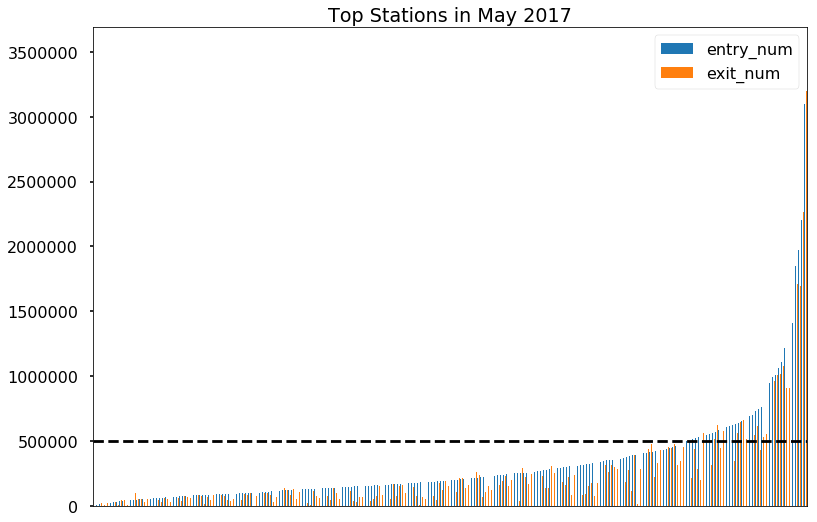

In [14]:
# Grouping all stations by name and linename to add up entries and exits for May
grouped_all_stations = df.groupby(['STATION','line_sort'])[['entry_num', 'exit_num']].sum().sort_values(by=['entry_num'])
grouped_all_stations.plot(kind='bar', title = "Top Stations in May 2017").xaxis.set_visible(False);
plt.axhline(y=500000, color = 'black', linestyle='--')

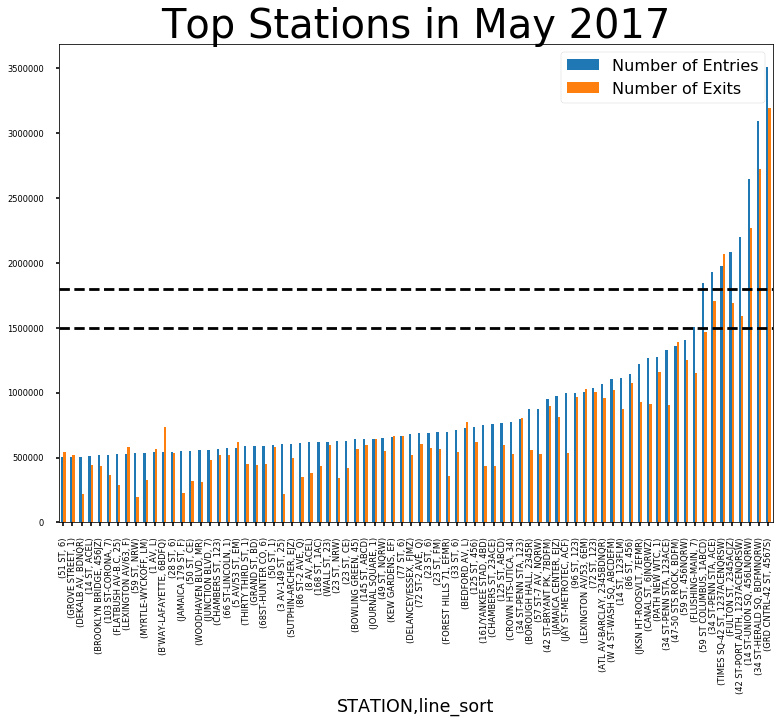

In [15]:
# Honed in on only the stations with greater than 500,000 entries for May
grouped_top_stations = grouped_all_stations[grouped_all_stations.entry_num > 500000]
grouped_top_stations.plot(kind='bar', title = "Top Stations in May 2017", fontsize = 'small');

plt.title('Top Stations in May 2017', size = 40)
plt.axhline(y=1500000, color = 'black', linestyle='--')
plt.axhline(y=1800000, color = 'black', linestyle='--')

L=plt.legend()
L.get_texts()[0].set_text('Number of Entries')
L.get_texts()[1].set_text('Number of Exits')

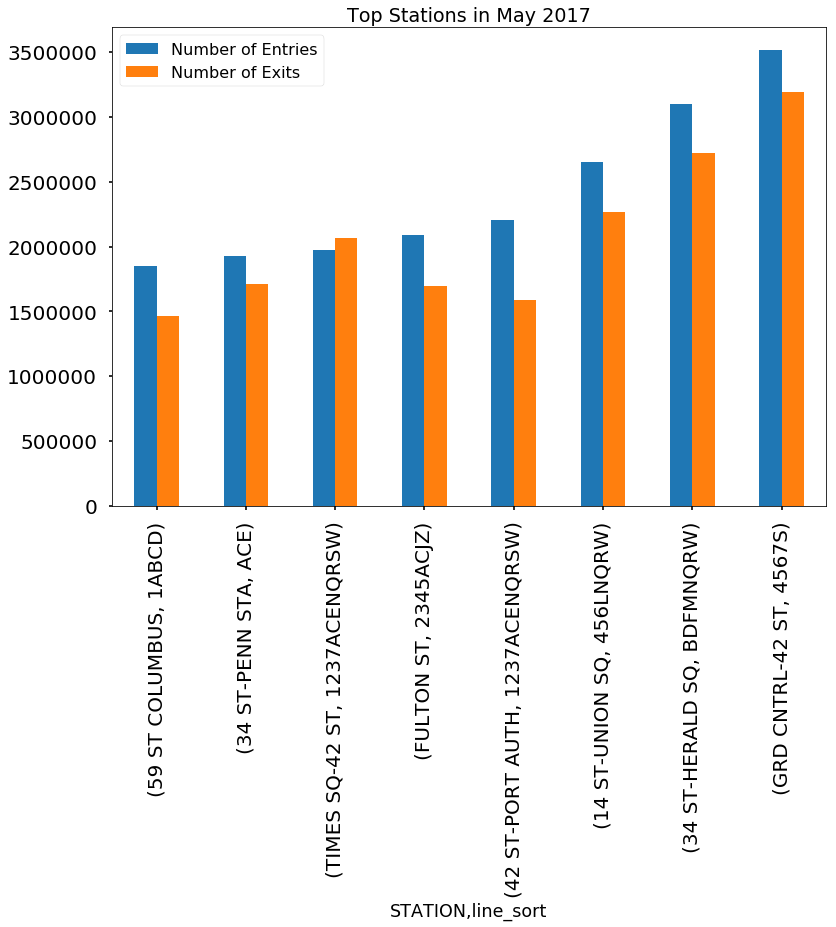

In [16]:
# Above we saw there was a natural gap between the top 8 stations and the rest
# So we focused in on those top 8
# Graphed by 
grouped_top_stations.tail(8).plot(kind='bar', title = "Top Stations in May 2017", fontsize = 20);
L=plt.legend()
L.get_texts()[0].set_text('Number of Entries')
L.get_texts()[1].set_text('Number of Exits')

In [17]:
# Grouped stations by time and took the average entries and exit per 4 block audit record
by_time = df.groupby(['STATION','line_sort','time'])[['entry_num', 'exit_num']].agg(['sum', 'count'])
by_time.columns = ['_'.join(col).strip() for col in by_time.columns.values]

[''.join(col).strip() for col in by_time.columns.values]
by_time['avg_entries'] = (by_time['entry_num_sum']/by_time['entry_num_count'])
by_time['avg_exits'] = (by_time['exit_num_sum']/by_time['exit_num_count'])

by_time = by_time.reset_index()
by_time.head()


,STATION,line_sort,time,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits
0,1 AV,L,00:00:00,78152.0,240,74275.0,240,325.633333,309.479167
1,1 AV,L,04:00:00,19300.0,280,14085.0,280,68.928571,50.303571
2,1 AV,L,08:00:00,36560.0,275,72540.0,275,132.945455,263.781818
3,1 AV,L,10:19:46,621.0,5,2577.0,5,124.200000,515.400000
4,1 AV,L,12:00:00,113837.0,280,131694.0,280,406.560714,470.335714


In [18]:
# Renamed time to time_parse
by_time = by_time.rename(index=str, columns={"time": "time_parse"})

# Added in columns for second and minute
by_time['time_sec'] = by_time.apply(lambda row: row.time_parse.second, axis=1)
by_time['time_min'] = by_time.apply(lambda row: row.time_parse.minute, axis=1)

# Eliminated any rows that didn't contain times with minutes of 0 and seconds of 0
# Eliminated these as they generally were errant audits
by_time_official = by_time[(by_time['time_min'] == 0) & (by_time['time_sec'] == 0)]

by_time_official.sort_values(by=['avg_entries'], ascending = False).head()


,STATION,line_sort,time_parse,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,time_sec,time_min
37021,YORK ST,F,21:00:00,107471.0,84,26287.0,84,1279.416667,312.940476,0,0
3423,BAY PKWY,N,09:00:00,129992.0,112,8940.0,112,1160.642857,79.821429,0,0
1840,23 ST,FM,20:00:00,308250.0,280,138267.0,280,1100.892857,493.810714,0,0
10265,GRAND ST,BD,20:00:00,228542.0,224,97530.0,224,1020.276786,435.401786,0,0
29656,PATH NEW WTC,1,21:00:00,3837.0,4,74.0,4,959.250000,18.500000,0,0


### Above was on whole dataset, now doing it for only the top stations and splitting by weekend and weekday datasets

In [21]:
# Filtering original Dataframe to only include top stations
top_df = grouped_all_stations.tail(8).reset_index()

# Created list of stations and lines to concatenate them
station_list = list(top_df.STATION)
line_list = list(top_df.line_sort) 
concattop = [m+ ' ' + str(n) for m,n in zip(station_list,line_list)]

# Created a 'topfilter' column to indicate a new key with station and linename
df['topfilter'] = df['STATION'] + ' ' + df['line_sort']

# Created a topdf object to hold the new dataframe with only stations + linenames found in list above
topdf = df[df.topfilter.isin(concattop)]
topdf = topdf.reset_index(drop=True)
topdf.head()

,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id,entry_num,exit_num,station_diff,time,Weekend,line_sort,topfilter
0,TIMES SQ-42 ST,ACENQRS1237W,6659709,7849605,2017-04-29 04:00:00,62,91.0,79.0,0.0,04:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
1,TIMES SQ-42 ST,ACENQRS1237W,6659813,7849730,2017-04-29 08:00:00,62,104.0,125.0,0.0,08:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
2,TIMES SQ-42 ST,ACENQRS1237W,6660076,7850435,2017-04-29 12:00:00,62,263.0,705.0,0.0,12:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
3,TIMES SQ-42 ST,ACENQRS1237W,6660426,7851175,2017-04-29 16:00:00,62,350.0,740.0,0.0,16:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
4,TIMES SQ-42 ST,ACENQRS1237W,6660872,7851937,2017-04-29 20:00:00,62,446.0,762.0,0.0,20:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW


In [22]:
# Split new topdf into two dataframes, one for weekday records and one for weekend records
weekdays_df = topdf[topdf.Weekend == False]
weekend_df = topdf[topdf.Weekend == True]
weekend_df.head(10)


,STATION,LINENAME,ENTRIES,EXITS,parsed_datetime,station_id,entry_num,exit_num,station_diff,time,Weekend,line_sort,topfilter
0,TIMES SQ-42 ST,ACENQRS1237W,6659709,7849605,2017-04-29 04:00:00,62,91.0,79.0,0.0,04:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
1,TIMES SQ-42 ST,ACENQRS1237W,6659813,7849730,2017-04-29 08:00:00,62,104.0,125.0,0.0,08:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
2,TIMES SQ-42 ST,ACENQRS1237W,6660076,7850435,2017-04-29 12:00:00,62,263.0,705.0,0.0,12:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
3,TIMES SQ-42 ST,ACENQRS1237W,6660426,7851175,2017-04-29 16:00:00,62,350.0,740.0,0.0,16:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
4,TIMES SQ-42 ST,ACENQRS1237W,6660872,7851937,2017-04-29 20:00:00,62,446.0,762.0,0.0,20:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
5,TIMES SQ-42 ST,ACENQRS1237W,6661258,7852315,2017-04-30 00:00:00,62,386.0,378.0,0.0,00:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
6,TIMES SQ-42 ST,ACENQRS1237W,6661360,7852360,2017-04-30 04:00:00,62,102.0,45.0,0.0,04:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
7,TIMES SQ-42 ST,ACENQRS1237W,6661407,7852440,2017-04-30 08:00:00,62,47.0,80.0,0.0,08:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
8,TIMES SQ-42 ST,ACENQRS1237W,6661567,7852892,2017-04-30 12:00:00,62,160.0,452.0,0.0,12:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW
9,TIMES SQ-42 ST,ACENQRS1237W,6661831,7853519,2017-04-30 16:00:00,62,264.0,627.0,0.0,16:00:00,True,1237ACENQRSW,TIMES SQ-42 ST 1237ACENQRSW


In [23]:
# Counting the entrances in each station in order to multiply our station averages by entrance counts
# Did this because our traffic averages were really avg station traffic per entrance 
entrances = pd.DataFrame(weekend_df.groupby('STATION').station_id.nunique())
entrances = entrances.reset_index()
entrances = entrances.rename(index=str, columns={"station_id": "entrance_count"})
entrances.reset_index(drop=True)

,STATION,entrance_count
0,14 ST-UNION SQ,38
1,34 ST-HERALD SQ,54
2,34 ST-PENN STA,56
3,42 ST-PORT AUTH,42
4,59 ST COLUMBUS,41
5,FULTON ST,89
6,GRD CNTRL-42 ST,65
7,TIMES SQ-42 ST,41


In [24]:
# Bringing in the zip code and income data for our top stations
station_income_zip = pd.DataFrame([['14 ST-UNION SQ', 10003,100791],\
                                   ['34 ST-HERALD SQ', 10001,85168],\
                                   ['34 ST-PENN STA', 10001,85168],\
                                   ['42 ST-PORT AUTH', 10018,105479],\
                                   ['59 ST COLUMBUS', 10023,115080],\
                                   ['FULTON ST', 10038,82190],\
                                   ['GRD CNTRL-42 ST', 10017,163683],\
                                   ['TIMES SQ-42 ST', 10036,83812]],\
                                columns=['station','zipcode','avg_income'])
station_income_zip.sort_values(by=['station'])

,station,zipcode,avg_income
0,14 ST-UNION SQ,10003,100791
1,34 ST-HERALD SQ,10001,85168
2,34 ST-PENN STA,10001,85168
3,42 ST-PORT AUTH,10018,105479
4,59 ST COLUMBUS,10023,115080
5,FULTON ST,10038,82190
6,GRD CNTRL-42 ST,10017,163683
7,TIMES SQ-42 ST,10036,83812


## Weekday Analysis

In [25]:
# Grouping weekdays dataframe by station+linename (aka topfilter) and time, then adding up entries and exits
by_time = weekdays_df.groupby(['topfilter','time'], as_index=False)[['entry_num', 'exit_num']].agg(['sum', 'count'])
by_time.columns = ['_'.join(col).strip() for col in by_time.columns.values]
[''.join(col).strip() for col in by_time.columns.values]

# Calculating average entries and exits
by_time['avg_entries'] = (by_time['entry_num_sum']/by_time['entry_num_count'])
by_time['avg_exits'] = (by_time['exit_num_sum']/by_time['exit_num_count'])

# Calculating average total traffic
by_time['avg_totals'] = (by_time['entry_num_sum']+by_time['exit_num_sum'])/(by_time['entry_num_count']+by_time['exit_num_count'])

# Creating columns for seconds and minutes
by_time = by_time.reset_index()
by_time = by_time.rename(index=str, columns={"time": "time_parse"})
by_time['time_sec'] = by_time.apply(lambda row: row.time_parse.second, axis=1)
by_time['time_min'] = by_time.apply(lambda row: row.time_parse.minute, axis=1)

# Eliminating rows with strange times as we did before
by_time_official = by_time[(by_time['time_min'] == 0) & (by_time['time_sec'] == 0)]

# Sorting by topfilter, time and then avg totals
by_time_official.sort_values(by=['topfilter', 'time_parse', 'avg_totals'], ascending = False).head()


,topfilter,time_parse,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,time_sec,time_min
109,TIMES SQ-42 ST 1237ACENQRSW,20:00:00,723950.0,818,422629.0,818,885.024450,516.661369,700.842910,0,0
108,TIMES SQ-42 ST 1237ACENQRSW,16:00:00,292149.0,818,328259.0,818,357.150367,401.294621,379.222494,0,0
107,TIMES SQ-42 ST 1237ACENQRSW,12:00:00,218015.0,818,610775.0,818,266.522005,746.668704,506.595355,0,0
103,TIMES SQ-42 ST 1237ACENQRSW,08:00:00,92439.0,818,149919.0,818,113.006112,183.275061,148.140587,0,0
102,TIMES SQ-42 ST 1237ACENQRSW,04:00:00,46706.0,818,17429.0,818,57.097800,21.306846,39.202323,0,0


### Morning Weekdays Analysis

In [26]:
# Creating column for hour
by_time_official['time_hour'] = by_time.apply(lambda row: row.time_parse.hour, axis=1)

# Using hour column to create subsets of dataframe and make afternoon and morning dataframes
weekday_morning = by_time_official[(by_time_official['time_hour'].map(lambda x: int(x)) < 13) & (by_time_official['time_hour'].map(lambda x: int(x)) > 8)]
weekday_afternoon = by_time_official[(by_time_official['time_hour'].map(lambda x: int(x)) > 13) & (by_time_official['time_hour'].map(lambda x: int(x)) < 23)]
weekday_afternoon.head()

/Users/windflower715/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


,topfilter,time_parse,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,time_sec,time_min,time_hour
6,14 ST-UNION SQ 456LNQRW,17:00:00,597384.0,757,415730.0,757,789.146631,549.180978,669.163804,0,0,17
7,14 ST-UNION SQ 456LNQRW,21:00:00,811592.0,760,435185.0,760,1067.884211,572.611842,820.248026,0,0,21
16,34 ST-HERALD SQ BDFMNQRW,16:00:00,508131.0,1078,466725.0,1078,471.364564,432.954545,452.159555,0,0,16
17,34 ST-HERALD SQ BDFMNQRW,20:00:00,1092774.0,1078,651092.0,1078,1013.705009,603.981447,808.843228,0,0,20
26,34 ST-PENN STA ACE,16:00:00,278439.0,1108,287414.0,1108,251.298736,259.398917,255.348827,0,0,16


In [27]:
weekday_morning = weekday_morning.reset_index(drop=True)
weekday_morning.sort_values(by=['topfilter', 'time_parse', 'avg_totals'], ascending = False).head()

,topfilter,time_parse,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,time_sec,time_min,time_hour
10,TIMES SQ-42 ST 1237ACENQRSW,12:00:00,218015.0,818,610775.0,818,266.522005,746.668704,506.595355,0,0,12
9,GRD CNTRL-42 ST 4567S,12:00:00,313421.0,537,419489.0,537,583.651769,781.171322,682.411546,0,0,12
8,GRD CNTRL-42 ST 4567S,09:00:00,215275.0,633,458051.0,633,340.086888,723.619273,531.853081,0,0,9
7,FULTON ST 2345ACJZ,11:00:00,77542.0,779,325766.0,779,99.540436,418.184852,258.862644,0,0,11
6,FULTON ST 2345ACJZ,09:00:00,146779.0,1000,282404.0,1000,146.779000,282.404000,214.591500,0,0,9


In [28]:
# Grouping weekday morning dataframe by topfilter (station + linename) to get avg traffic for each station+linename
gd_weekday_morning = weekday_morning.groupby(['topfilter'], as_index=False)[['entry_num_sum', 'entry_num_count', 'exit_num_sum', 'exit_num_count']].sum()
gd_weekday_morning['avg_entries'] = (gd_weekday_morning['entry_num_sum']/gd_weekday_morning['entry_num_count'])
gd_weekday_morning['avg_exits'] = (gd_weekday_morning['exit_num_sum']/gd_weekday_morning['exit_num_count'])
gd_weekday_morning['avg_totals'] = (gd_weekday_morning['entry_num_sum']+gd_weekday_morning['exit_num_sum'])/(gd_weekday_morning['entry_num_count']+gd_weekday_morning['exit_num_count'])

# Adding in zip code and average income for the stations
gd_weekday_morning.sort_values(by=['topfilter'], ascending = True)
gd_weekday_morning['zip_code'] = station_income_zip['zipcode']
gd_weekday_morning['avg_income'] = station_income_zip['avg_income']
gd_weekday_morning['entrance_count'] = list(entrances['entrance_count'])
gd_weekday_morning['avg_totals_station'] = ((gd_weekday_morning['avg_totals'] * gd_weekday_morning['entrance_count'])/4)

gd_weekday_morning.sort_values(by=['avg_totals_station'], ascending = False).head()


,topfilter,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,zip_code,avg_income,entrance_count,avg_totals_station
6,GRD CNTRL-42 ST 4567S,528696.0,1170,877540.0,1170,451.876923,750.034188,600.955556,10017,163683,65,9765.527778
1,34 ST-HERALD SQ BDFMNQRW,457526.0,1079,765472.0,1079,424.027804,709.427247,566.727525,10001,85168,54,7650.821594
2,34 ST-PENN STA ACE,493510.0,1111,348704.0,1111,444.203420,313.864986,379.034203,10001,85168,56,5306.478848
5,FULTON ST 2345ACJZ,224321.0,1779,608170.0,1779,126.093873,341.860596,233.977234,10038,82190,89,5205.993465
7,TIMES SQ-42 ST 1237ACENQRSW,218015.0,818,610775.0,818,266.522005,746.668704,506.595355,10036,83812,41,5192.602384


### Afternoon Weekdays Analysis

In [75]:
# Repeating steps above for weekday afternoon data
gd_weekday_afternoon = weekday_afternoon.groupby(['topfilter'], as_index=False)[['entry_num_sum', 'entry_num_count', 'exit_num_sum', 'exit_num_count']].sum()
gd_weekday_afternoon['avg_entries'] = (gd_weekday_afternoon['entry_num_sum']/gd_weekday_afternoon['entry_num_count'])
gd_weekday_afternoon['avg_exits'] = (gd_weekday_afternoon['exit_num_sum']/gd_weekday_afternoon['exit_num_count'])
gd_weekday_afternoon['avg_totals'] = (gd_weekday_afternoon['entry_num_sum']+gd_weekday_afternoon['exit_num_sum'])/(gd_weekday_afternoon['entry_num_count']+gd_weekday_afternoon['exit_num_count'])

gd_weekday_afternoon.sort_values(by=['topfilter'], ascending = True)
gd_weekday_afternoon['zip_code'] = station_income_zip['zipcode']
gd_weekday_afternoon['avg_income'] = station_income_zip['avg_income']
gd_weekday_afternoon['entrance_count'] = list(entrances['entrance_count'])
gd_weekday_afternoon['avg_totals_station'] = ((gd_weekday_afternoon['avg_totals'] * gd_weekday_afternoon['entrance_count'])/4)

gd_weekday_afternoon.sort_values(by=['avg_totals_station'], ascending = False)

,topfilter,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,zip_code,avg_income,entrance_count,avg_totals_station
6,GRD CNTRL-42 ST 4567S,1961205.0,2332,1148095.0,2332,840.996998,492.322041,666.659520,10017,163683,65,10833.217196
1,34 ST-HERALD SQ BDFMNQRW,1600905.0,2156,1117817.0,2156,742.534787,518.467996,630.501391,10001,85168,54,8511.768785
0,14 ST-UNION SQ 456LNQRW,1408976.0,1517,850915.0,1517,928.791035,560.919578,744.855307,10003,100791,38,7076.125412
5,FULTON ST 2345ACJZ,1283556.0,3557,551096.0,3557,360.853528,154.932809,257.893168,10038,82190,89,5738.122997
7,TIMES SQ-42 ST 1237ACENQRSW,1016099.0,1636,750888.0,1636,621.087408,458.977995,540.032702,10036,83812,41,5535.335193
2,34 ST-PENN STA ACE,743121.0,2216,815097.0,2216,335.343412,367.823556,351.583484,10001,85168,56,4922.168773
4,59 ST COLUMBUS 1ABCD,990361.0,1640,517140.0,1640,603.878659,315.329268,459.603963,10023,115080,41,4710.940625
3,42 ST-PORT AUTH 1237ACENQRSW,728211.0,1868,848126.0,1868,389.834582,454.028908,421.931745,10018,105479,42,4430.283324


## Weekend Analysis

In [30]:
# Doing same as above but for weekend dataframe
by_time = weekend_df.groupby(['topfilter','time'], as_index=False)[['entry_num', 'exit_num']].agg(['sum', 'count'])
by_time.columns = ['_'.join(col).strip() for col in by_time.columns.values]
[''.join(col).strip() for col in by_time.columns.values]
by_time['avg_entries'] = (by_time['entry_num_sum']/by_time['entry_num_count'])
by_time['avg_exits'] = (by_time['exit_num_sum']/by_time['exit_num_count'])
by_time['avg_totals'] = (by_time['entry_num_sum']+by_time['exit_num_sum'])/(by_time['entry_num_count']+by_time['exit_num_count'])


by_time = by_time.reset_index()

by_time = by_time.rename(index=str, columns={"time": "time_parse"})

by_time['time_sec'] = by_time.apply(lambda row: row.time_parse.second, axis=1)

by_time['time_min'] = by_time.apply(lambda row: row.time_parse.minute, axis=1)

by_time_official = by_time[(by_time['time_min'] == 0) & (by_time['time_sec'] == 0)]

by_time_official.sort_values(by=['topfilter', 'time_parse', 'avg_totals'], ascending = False)


,topfilter,time_parse,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,time_sec,time_min
67,TIMES SQ-42 ST 1237ACENQRSW,20:00:00,107841.0,328,123210.0,328,328.783537,375.640244,352.211890,0,0
66,TIMES SQ-42 ST 1237ACENQRSW,16:00:00,70512.0,328,131282.0,328,214.975610,400.250000,307.612805,0,0
65,TIMES SQ-42 ST 1237ACENQRSW,12:00:00,40429.0,328,76979.0,328,123.259146,234.692073,178.975610,0,0
64,TIMES SQ-42 ST 1237ACENQRSW,08:00:00,11683.0,328,17672.0,328,35.618902,53.878049,44.748476,0,0
63,TIMES SQ-42 ST 1237ACENQRSW,04:00:00,33922.0,328,11727.0,328,103.420732,35.753049,69.586890,0,0
62,TIMES SQ-42 ST 1237ACENQRSW,00:00:00,51204.0,164,34530.0,164,312.219512,210.548780,261.384146,0,0
61,GRD CNTRL-42 ST 4567S,21:00:00,39900.0,256,40806.0,256,155.859375,159.398438,157.628906,0,0
60,GRD CNTRL-42 ST 4567S,20:00:00,75101.0,221,51560.0,221,339.823529,233.303167,286.563348,0,0
59,GRD CNTRL-42 ST 4567S,17:00:00,45776.0,256,52476.0,256,178.812500,204.984375,191.898438,0,0
58,GRD CNTRL-42 ST 4567S,16:00:00,70043.0,221,55487.0,221,316.936652,251.072398,284.004525,0,0


### Morning Weekend Analysis

In [77]:
by_time_official['time_hour'] = by_time.apply(lambda row: row.time_parse.hour, axis=1)

weekend_morning = by_time_official[(by_time_official['time_hour'].map(lambda x: int(x)) < 12) & (by_time_official['time_hour'].map(lambda x: int(x)) > 5)]
weekend_afternoon = by_time_official[(by_time_official['time_hour'].map(lambda x: int(x)) > 14) & (by_time_official['time_hour'].map(lambda x: int(x)) < 21)]

/Users/matiasbeeck/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [78]:
weekend_morning = weekend_morning.reset_index(drop=True)
weekend_morning.sort_values(by=['topfilter', 'time_parse', 'avg_totals'], ascending = False)

,topfilter,time_parse,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,time_sec,time_min,time_hour
12,TIMES SQ-42 ST 1237ACENQRSW,08:00:00,11683.0,328,17672.0,328,35.618902,53.878049,44.748476,0,0,8
11,GRD CNTRL-42 ST 4567S,09:00:00,9195.0,255,20032.0,255,36.058824,78.556863,57.307843,0,0,9
10,GRD CNTRL-42 ST 4567S,08:00:00,6665.0,222,11412.0,222,30.022523,51.405405,40.713964,0,0,8
9,FULTON ST 2345ACJZ,11:00:00,9360.0,312,23521.0,312,30.000000,75.387821,52.693910,0,0,11
8,FULTON ST 2345ACJZ,09:00:00,5565.0,398,3340.0,398,13.982412,8.391960,11.187186,0,0,9
7,FULTON ST 2345ACJZ,07:00:00,1456.0,312,3715.0,312,4.666667,11.907051,8.286859,0,0,7
6,59 ST COLUMBUS 1ABCD,08:00:00,7907.0,328,15619.0,328,24.106707,47.618902,35.862805,0,0,8
5,42 ST-PORT AUTH 1237ACENQRSW,10:00:00,9439.0,80,9658.0,80,117.987500,120.725000,119.356250,0,0,10
4,42 ST-PORT AUTH 1237ACENQRSW,08:00:00,17904.0,254,14432.0,254,70.488189,56.818898,63.653543,0,0,8
3,42 ST-PORT AUTH 1237ACENQRSW,06:00:00,7193.0,80,3471.0,80,89.912500,43.387500,66.650000,0,0,6


In [79]:
gd_weekend_morning = weekend_morning.groupby(['topfilter'], as_index=False)[['entry_num_sum', 'entry_num_count', 'exit_num_sum', 'exit_num_count']].sum()
gd_weekend_morning['avg_entries'] = (gd_weekend_morning['entry_num_sum']/gd_weekend_morning['entry_num_count'])
gd_weekend_morning['avg_exits'] = (gd_weekend_morning['exit_num_sum']/gd_weekend_morning['exit_num_count'])
gd_weekend_morning['avg_totals'] = (gd_weekend_morning['entry_num_sum']+gd_weekend_morning['exit_num_sum'])/(gd_weekend_morning['entry_num_count']+gd_weekend_morning['exit_num_count'])

gd_weekend_morning.sort_values(by=['topfilter'], ascending = True)
gd_weekend_morning['zip_code'] = station_income_zip['zipcode']
gd_weekend_morning['avg_income'] = station_income_zip['avg_income']
gd_weekend_morning['entrance_count'] = list(entrances['entrance_count'])
gd_weekend_morning['avg_totals_station'] = ((gd_weekend_morning['avg_totals'] * gd_weekend_morning['entrance_count'])/4)

gd_weekend_morning.sort_values(by=['avg_totals_station'], ascending = False)

,topfilter,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,zip_code,avg_income,entrance_count,avg_totals_station
6,GRD CNTRL-42 ST 4567S,15860.0,477,31444.0,477,33.249476,65.920335,49.584906,10017,163683,65,805.754717
3,42 ST-PORT AUTH 1237ACENQRSW,34536.0,414,27561.0,414,83.420290,66.572464,74.996377,10018,105479,42,787.461957
0,14 ST-UNION SQ 456LNQRW,16609.0,303,32779.0,303,54.815182,108.181518,81.498350,10003,100791,38,774.234323
1,34 ST-HERALD SQ BDFMNQRW,12806.0,430,23431.0,430,29.781395,54.490698,42.136047,10001,85168,54,568.836628
5,FULTON ST 2345ACJZ,16381.0,1022,30576.0,1022,16.028376,29.917808,22.973092,10038,82190,89,511.151296
7,TIMES SQ-42 ST 1237ACENQRSW,11683.0,328,17672.0,328,35.618902,53.878049,44.748476,10036,83812,41,458.671875
2,34 ST-PENN STA ACE,11476.0,445,17290.0,445,25.788764,38.853933,32.321348,10001,85168,56,452.498876
4,59 ST COLUMBUS 1ABCD,7907.0,328,15619.0,328,24.106707,47.618902,35.862805,10023,115080,41,367.593750


### Afternoon Weekend Analysis

In [80]:
gd_weekend_afternoon = weekend_afternoon.groupby(['topfilter'], as_index=False)[['entry_num_sum', 'entry_num_count', 'exit_num_sum', 'exit_num_count']].sum()
gd_weekend_afternoon['avg_entries'] = (gd_weekend_afternoon['entry_num_sum']/gd_weekend_afternoon['entry_num_count'])
gd_weekend_afternoon['avg_exits'] = (gd_weekend_afternoon['exit_num_sum']/gd_weekend_afternoon['exit_num_count'])
gd_weekend_afternoon['avg_totals'] = (gd_weekend_afternoon['entry_num_sum']+gd_weekend_afternoon['exit_num_sum'])/(gd_weekend_afternoon['entry_num_count']+gd_weekend_afternoon['exit_num_count'])

gd_weekend_afternoon.sort_values(by=['topfilter'], ascending = True)
gd_weekend_afternoon['zip_code'] = station_income_zip['zipcode']
gd_weekend_afternoon['avg_income'] = station_income_zip['avg_income']
gd_weekend_afternoon['entrance_count'] = list(entrances['entrance_count'])
gd_weekend_afternoon['avg_totals_station'] = ((gd_weekend_afternoon['avg_totals'] * gd_weekend_afternoon['entrance_count'])/4)

gd_weekend_afternoon.sort_values(by=['avg_totals_station'], ascending = False)

,topfilter,entry_num_sum,entry_num_count,exit_num_sum,exit_num_count,avg_entries,avg_exits,avg_totals,zip_code,avg_income,entrance_count,avg_totals_station
0,14 ST-UNION SQ 456LNQRW,155453.0,304,143510.0,304,511.358553,472.072368,491.715461,10003,100791,38,4671.296875
1,34 ST-HERALD SQ BDFMNQRW,316734.0,863,269850.0,863,367.015064,312.688297,339.851680,10001,85168,54,4587.997683
6,GRD CNTRL-42 ST 4567S,190920.0,698,159523.0,698,273.524355,228.542980,251.033668,10017,163683,65,4079.297099
7,TIMES SQ-42 ST 1237ACENQRSW,178353.0,656,254492.0,656,271.879573,387.945122,329.912348,10036,83812,41,3381.601562
3,42 ST-PORT AUTH 1237ACENQRSW,169781.0,589,158678.0,589,288.252971,269.402377,278.827674,10018,105479,42,2927.690577
4,59 ST COLUMBUS 1ABCD,204192.0,656,150125.0,656,311.268293,228.849085,270.058689,10023,115080,41,2768.101562
2,34 ST-PENN STA ACE,175772.0,889,171065.0,889,197.718785,192.424072,195.071429,10001,85168,56,2731.000000
5,FULTON ST 2345ACJZ,93136.0,1021,74904.0,1021,91.220372,73.363369,82.291871,10038,82190,89,1830.994123


### Weekday Scatterplots of Traffic v Income

In [81]:
# Setting up Weekday Morning Dataframe to make scatterplot of traffic vs income
wkday_morn = gd_weekday_morning[['topfilter','avg_totals_station','avg_income','zip_code']]
wkday_morn = wkday_morn.rename(index=str, columns={"topfilter": "Station", "avg_totals_station": "Traffic", "avg_income": "Income","zip_code": "Zip"})

wkday_morn

,Station,Traffic,Income,Zip
0,14 ST-UNION SQ 456LNQRW,3448.820013,100791,10003
1,34 ST-HERALD SQ BDFMNQRW,7650.821594,85168,10001
2,34 ST-PENN STA ACE,5306.478848,85168,10001
3,42 ST-PORT AUTH 1237ACENQRSW,4673.274281,105479,10018
4,59 ST COLUMBUS 1ABCD,4186.779141,115080,10023
5,FULTON ST 2345ACJZ,5205.993465,82190,10038
6,GRD CNTRL-42 ST 4567S,9765.527778,163683,10017
7,TIMES SQ-42 ST 1237ACENQRSW,5192.602384,83812,10036


Text(0,0.5,'Income')

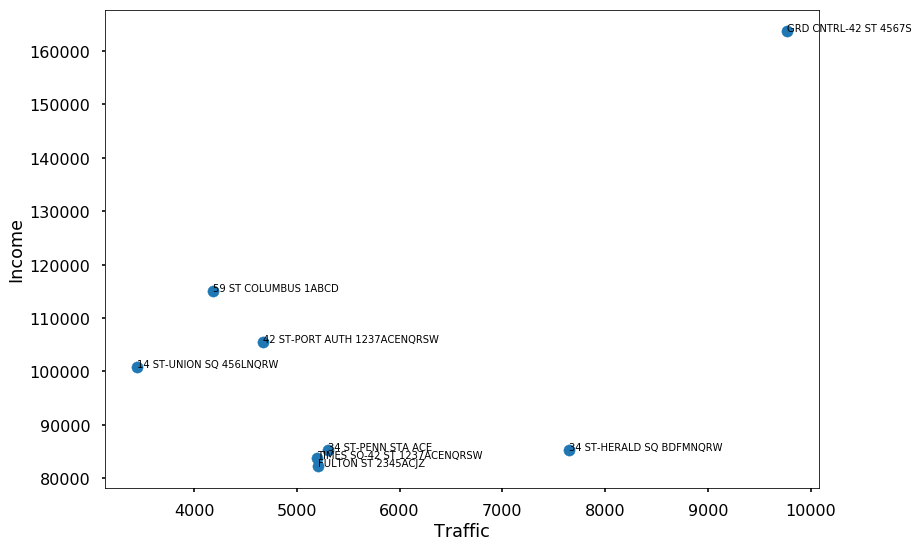

In [82]:
y = wkday_morn.Income.values.tolist()
z = wkday_morn.Traffic.values.tolist()
n = wkday_morn.Station.values.tolist()

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel('Traffic')
ax.set_ylabel('Income')    
# from matplotlib import cm
# cmap = cm.get_cmap('Spectral')
# wkday_morn.plot('Income', 'Traffic', kind='scatter', ax=ax, s=120, linewidth=0, 
#         c=range(len(wkday_morn)), colormap=cmap)

# for k, v in wkday_morn.iterrows():
#     ax.annotate(k, v,
#                 xytext=(10,-5), textcoords='offset points',
#                 family='sans-serif', fontsize=18, color='darkslategrey')


In [83]:
# Doing the same as above but for Weekday Afternoon
wkday_aft = gd_weekday_afternoon[['topfilter','avg_totals_station','avg_income','zip_code']]
wkday_aft = wkday_aft.rename(index=str, columns={"topfilter": "Station", "avg_totals_station": "Traffic", "avg_income": "Income","zip_code": "Zip"})

wkday_aft

,Station,Traffic,Income,Zip
0,14 ST-UNION SQ 456LNQRW,7076.125412,100791,10003
1,34 ST-HERALD SQ BDFMNQRW,8511.768785,85168,10001
2,34 ST-PENN STA ACE,4922.168773,85168,10001
3,42 ST-PORT AUTH 1237ACENQRSW,4430.283324,105479,10018
4,59 ST COLUMBUS 1ABCD,4710.940625,115080,10023
5,FULTON ST 2345ACJZ,5738.122997,82190,10038
6,GRD CNTRL-42 ST 4567S,10833.217196,163683,10017
7,TIMES SQ-42 ST 1237ACENQRSW,5535.335193,83812,10036


Text(0,0.5,'Income')

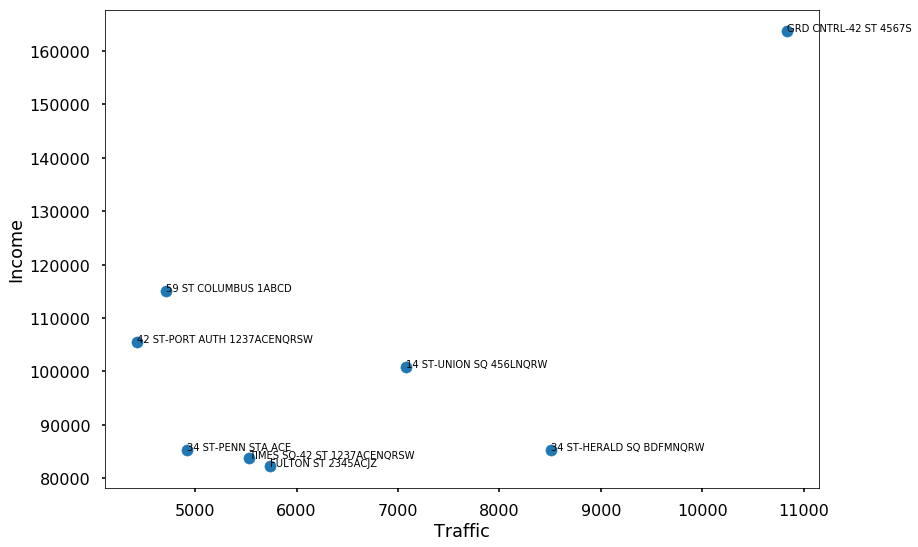

In [84]:
y = wkday_aft.Income.values.tolist()
z = wkday_aft.Traffic.values.tolist()
n = wkday_aft.Station.values.tolist()

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
ax.set_xlabel('Traffic')
ax.set_ylabel('Income')    

### Weekend Scatterplots of Traffic v Income

In [86]:
# Doing same as above but for Weekend Mornings and afternoons
wknd_morn = gd_weekend_morning[['topfilter','avg_totals_station','avg_income','zip_code']]
wknd_morn = wknd_morn.rename(index=str, columns={"topfilter": "Station", "avg_totals_station": "Traffic", "avg_income": "Income","zip_code": "Zip"})

wknd_morn

,Station,Traffic,Income,Zip
0,14 ST-UNION SQ 456LNQRW,774.234323,100791,10003
1,34 ST-HERALD SQ BDFMNQRW,568.836628,85168,10001
2,34 ST-PENN STA ACE,452.498876,85168,10001
3,42 ST-PORT AUTH 1237ACENQRSW,787.461957,105479,10018
4,59 ST COLUMBUS 1ABCD,367.593750,115080,10023
5,FULTON ST 2345ACJZ,511.151296,82190,10038
6,GRD CNTRL-42 ST 4567S,805.754717,163683,10017
7,TIMES SQ-42 ST 1237ACENQRSW,458.671875,83812,10036


Text(0,0.5,'Income')

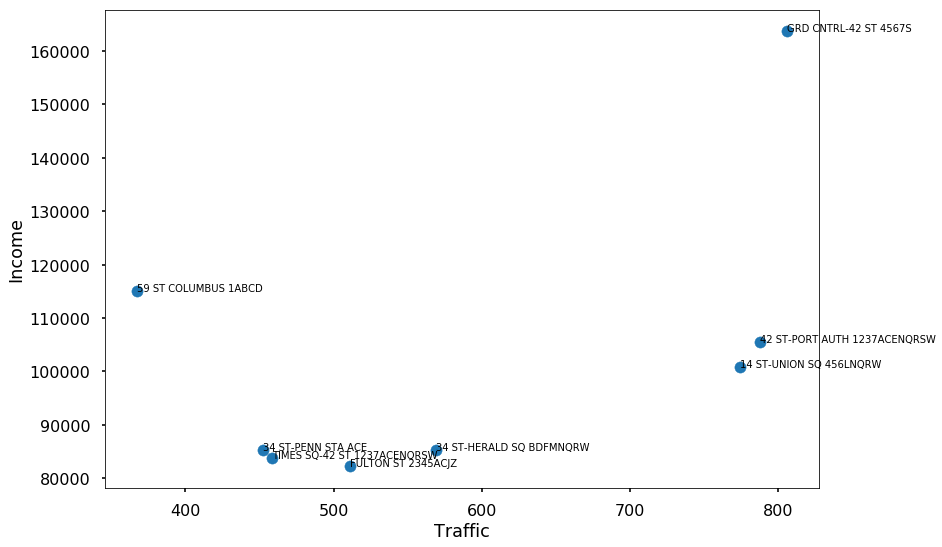

In [87]:
y = wknd_morn.Income.values.tolist()
z = wknd_morn.Traffic.values.tolist()
n = wknd_morn.Station.values.tolist()

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))
    
ax.set_xlabel('Traffic')
ax.set_ylabel('Income')    

In [88]:
# Weekend Afternoon
wknd_aft = gd_weekend_afternoon[['topfilter','avg_totals_station','avg_income','zip_code']]
wknd_aft = wknd_aft.rename(index=str, columns={"topfilter": "Station", "avg_totals_station": "Traffic", "avg_income": "Income","zip_code": "Zip"})
wknd_aft


,Station,Traffic,Income,Zip
0,14 ST-UNION SQ 456LNQRW,4671.296875,100791,10003
1,34 ST-HERALD SQ BDFMNQRW,4587.997683,85168,10001
2,34 ST-PENN STA ACE,2731.000000,85168,10001
3,42 ST-PORT AUTH 1237ACENQRSW,2927.690577,105479,10018
4,59 ST COLUMBUS 1ABCD,2768.101562,115080,10023
5,FULTON ST 2345ACJZ,1830.994123,82190,10038
6,GRD CNTRL-42 ST 4567S,4079.297099,163683,10017
7,TIMES SQ-42 ST 1237ACENQRSW,3381.601562,83812,10036


Text(0,0.5,'Income')

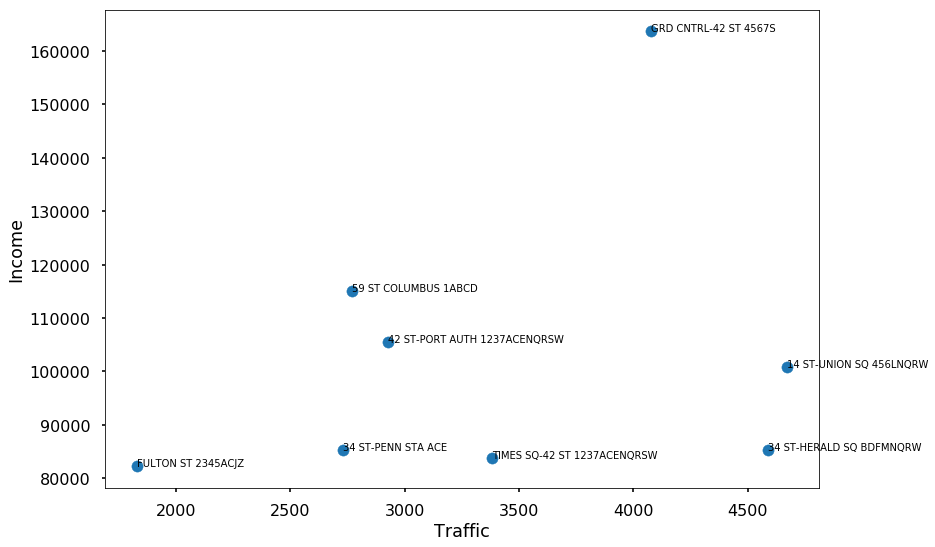

In [89]:
y = wknd_aft.Income.values.tolist()
z = wknd_aft.Traffic.values.tolist()
n = wknd_aft.Station.values.tolist()

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i],y[i]))

ax.set_xlabel('Traffic')
ax.set_ylabel('Income')    

## Traffic Comparisons By Weekday & Weekend

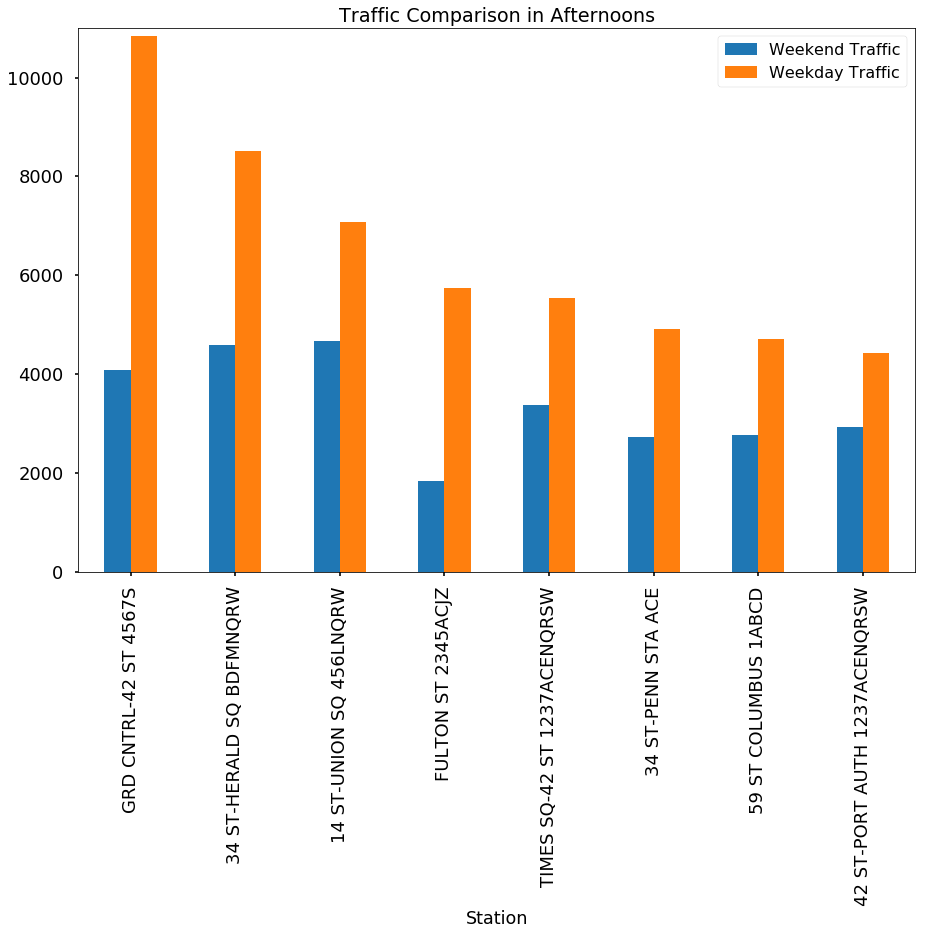

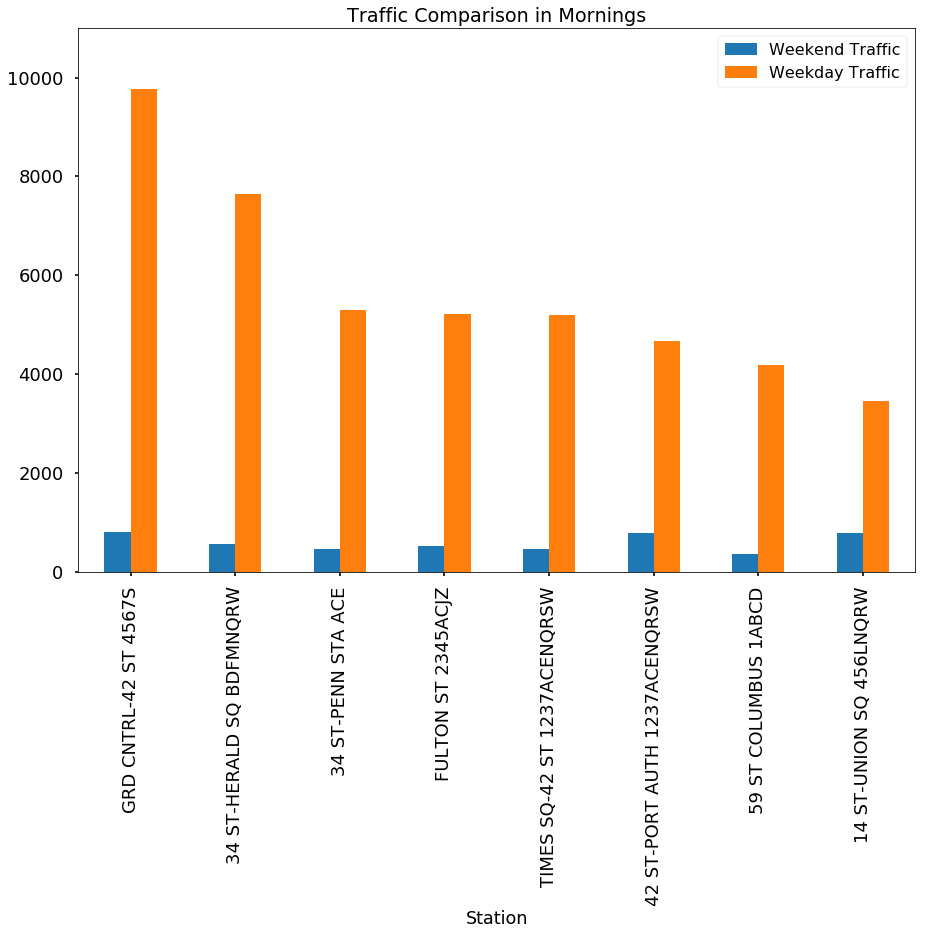

In [90]:
a=wknd_aft.groupby('Station').sum()
b=wkday_aft.groupby('Station').sum()

c=wknd_morn.groupby('Station').sum()
d=wkday_morn.groupby('Station').sum()

a=a.drop('Zip',1)
b=b.drop('Zip',1)

c=c.drop('Zip',1)
d=d.drop('Zip',1)

a['Weekday Traffic']=b.Traffic
a['Weekend Traffic'] = a['Traffic']

c['Weekday Traffic']=d.Traffic
c['Weekend Traffic']=c['Traffic']

a = a.sort_values(by=['Weekday Traffic'], ascending = False)
c = c.sort_values(by=['Weekday Traffic'], ascending = False)


ax = a[['Weekend Traffic','Weekday Traffic']].plot(kind='bar', ylim=[0,11000], title ="Traffic Comparison in Afternoons", figsize=(15, 10), legend=True, fontsize=18)
fig = ax.get_figure()
fig.savefig('afternoontraffic.png')
ax = c[['Weekend Traffic','Weekday Traffic']].plot(kind='bar', ylim=[0,11000], title ="Traffic Comparison in Mornings", figsize=(15, 10), legend=True, fontsize=18)
fig = ax.get_figure()
fig.savefig('morningtraffic.png')

## Income and Charitable Donation Analysis

In [91]:
inc=c.Income.tolist()
[int(0.001*k) for k in sorted([k-(sum(inc)/len(inc)) for k in inc])]
#look at range of values of income

[-20, -18, -17, -17, -1, 2, 12, 61]

In [92]:
giftfac=np.linspace(3,4,15)/4
giftfac
#look at range of relative gift value between 3/4 and 1

array([ 0.75      ,  0.76785714,  0.78571429,  0.80357143,  0.82142857,
        0.83928571,  0.85714286,  0.875     ,  0.89285714,  0.91071429,
        0.92857143,  0.94642857,  0.96428571,  0.98214286,  1.        ])

In [93]:
per=[(((((i-50000.0)*2/3)/100000)/4.0)+0.75) for i in inc]  #for each station's income, find
        #where it is between 50k and 200k and get the linear interpolation % between 3/4 and 1
scaper=[i/.9394716666666667 for i in per] #scale by largest station
scaper
#get relative values per station scaled by largest station

[1.0,
 0.8607107186131211,
 0.8607107186131211,
 0.8554276073608748,
 0.8583051112061212,
 0.8967433823620723,
 0.9137760053079479,
 0.888426651149671]

In [94]:
c['scaper']=scaper #put above stuff into dataFrame

In [95]:
c['wdEV']=c.scaper * c['Weekday Traffic'] #add back to main dataframe
c

,Traffic,Income,Weekday Traffic,Weekend Traffic,scaper,wdEV
Station,,,,,,
GRD CNTRL-42 ST 4567S,805.754717,163683,9765.527778,805.754717,1.000000,9765.527778
34 ST-HERALD SQ BDFMNQRW,568.836628,85168,7650.821594,568.836628,0.860711,6585.144152
34 ST-PENN STA ACE,452.498876,85168,5306.478848,452.498876,0.860711,4567.343222
FULTON ST 2345ACJZ,511.151296,82190,5205.993465,511.151296,0.855428,4453.350534
TIMES SQ-42 ST 1237ACENQRSW,458.671875,83812,5192.602384,458.671875,0.858305,4456.837167
42 ST-PORT AUTH 1237ACENQRSW,787.461957,105479,4673.274281,787.461957,0.896743,4190.727785
59 ST COLUMBUS 1ABCD,367.593750,115080,4186.779141,367.593750,0.913776,3825.778319
14 ST-UNION SQ 456LNQRW,774.234323,100791,3448.820013,774.234323,0.888427,3064.023615


In [96]:
c['scaper']=scaper
c['scapertra'] = c['Weekday Traffic']/(c['Weekday Traffic'].max())
c['wdEV'] = c.scapertra * c.scaper
c['scapertrawe'] = c['Weekend Traffic']/(c['Weekend Traffic'].max())
c['weEV'] = c.scapertrawe * c.scaper
c #multiply by traffic values for different options

,Traffic,Income,Weekday Traffic,Weekend Traffic,scaper,wdEV,scapertra,scapertrawe,weEV
Station,,,,,,,,,
GRD CNTRL-42 ST 4567S,805.754717,163683,9765.527778,805.754717,1.000000,1.000000,1.000000,1.000000,1.000000
34 ST-HERALD SQ BDFMNQRW,568.836628,85168,7650.821594,568.836628,0.860711,0.674325,0.783452,0.705967,0.607634
34 ST-PENN STA ACE,452.498876,85168,5306.478848,452.498876,0.860711,0.467701,0.543389,0.561584,0.483361
FULTON ST 2345ACJZ,511.151296,82190,5205.993465,511.151296,0.855428,0.456028,0.533099,0.634376,0.542663
TIMES SQ-42 ST 1237ACENQRSW,458.671875,83812,5192.602384,458.671875,0.858305,0.456385,0.531728,0.569245,0.488586
42 ST-PORT AUTH 1237ACENQRSW,787.461957,105479,4673.274281,787.461957,0.896743,0.429135,0.478548,0.977297,0.876385
59 ST COLUMBUS 1ABCD,367.593750,115080,4186.779141,367.593750,0.913776,0.391764,0.428730,0.456210,0.416874
14 ST-UNION SQ 456LNQRW,774.234323,100791,3448.820013,774.234323,0.888427,0.313759,0.353163,0.960881,0.853672


In [97]:
a['scaper']=scaper
a['scapertra'] = a['Weekday Traffic']/(a['Weekday Traffic'].max())
a['wdEV'] = a.scapertra * a.scaper
a['scapertrawe'] = a['Weekend Traffic']/(a['Weekend Traffic'].max())
a['weEV'] = a.scapertrawe * a.scaper
a #more of above but incorporating from the other table too to get morning and afternoon data

,Traffic,Income,Weekday Traffic,Weekend Traffic,scaper,scapertra,wdEV,scapertrawe,weEV
Station,,,,,,,,,
GRD CNTRL-42 ST 4567S,4079.297099,163683,10833.217196,4079.297099,1.000000,1.000000,1.000000,0.873269,0.873269
34 ST-HERALD SQ BDFMNQRW,4587.997683,85168,8511.768785,4587.997683,0.860711,0.785710,0.676269,0.982168,0.845362
14 ST-UNION SQ 456LNQRW,4671.296875,100791,7076.125412,4671.296875,0.860711,0.653188,0.562206,1.000000,0.860711
FULTON ST 2345ACJZ,1830.994123,82190,5738.122997,1830.994123,0.855428,0.529679,0.453102,0.391967,0.335299
TIMES SQ-42 ST 1237ACENQRSW,3381.601562,83812,5535.335193,3381.601562,0.858305,0.510959,0.438559,0.723911,0.621336
34 ST-PENN STA ACE,2731.000000,85168,4922.168773,2731.000000,0.896743,0.454359,0.407443,0.584634,0.524267
59 ST COLUMBUS 1ABCD,2768.101562,115080,4710.940625,2768.101562,0.913776,0.434861,0.397365,0.592577,0.541482
42 ST-PORT AUTH 1237ACENQRSW,2927.690577,105479,4430.283324,2927.690577,0.888427,0.408954,0.363325,0.626740,0.556813


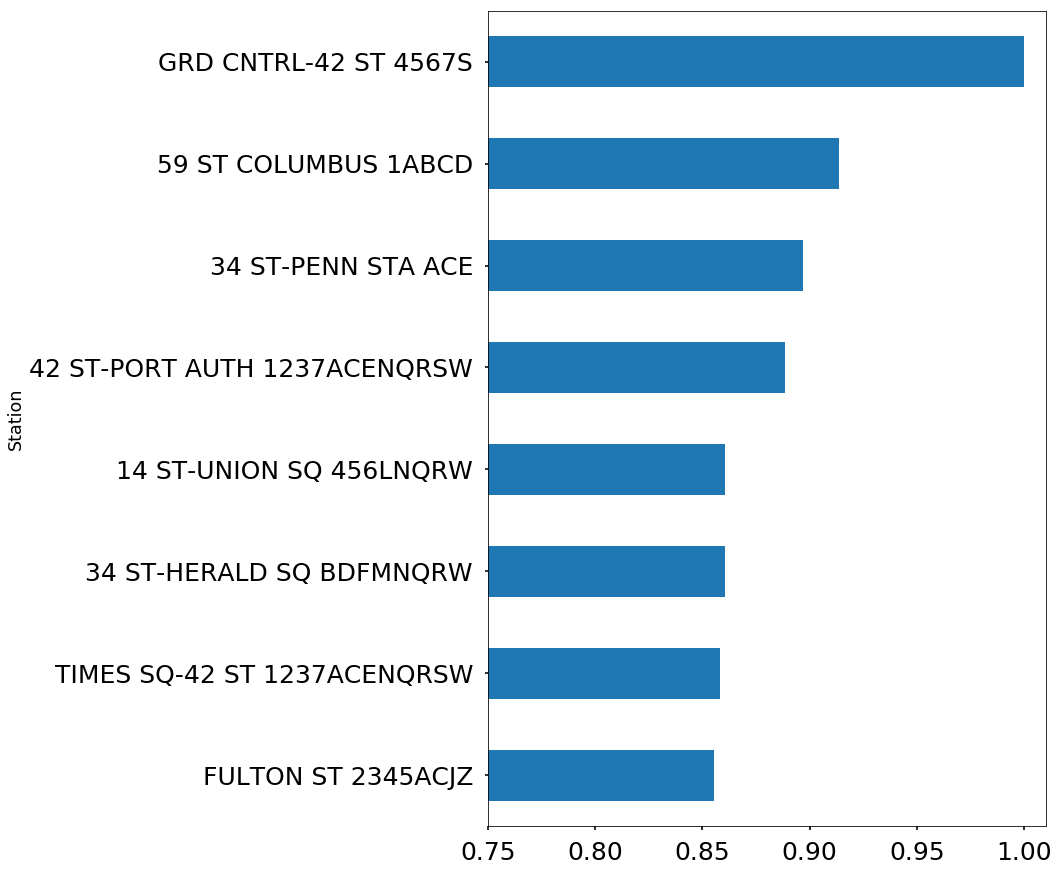

In [98]:
ax = a['scaper'].sort_values().plot(kind='barh', figsize=(10, 15), legend=False, fontsize=25, xlim=[0.75,1.01])
# graph relative gift size

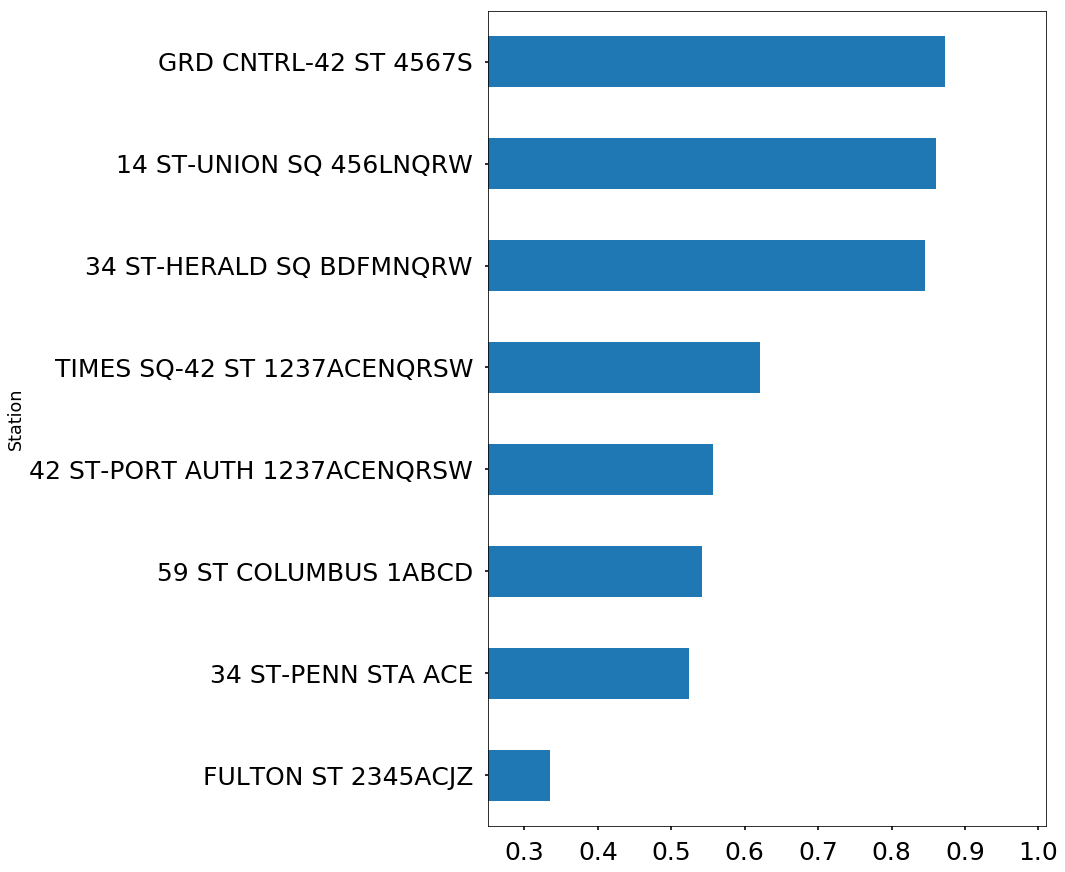

In [57]:
ax = a['weEV'].sort_values().plot(kind='barh', figsize=(10, 15) ,legend=False, fontsize=25, xlim=[0.25,1.01])


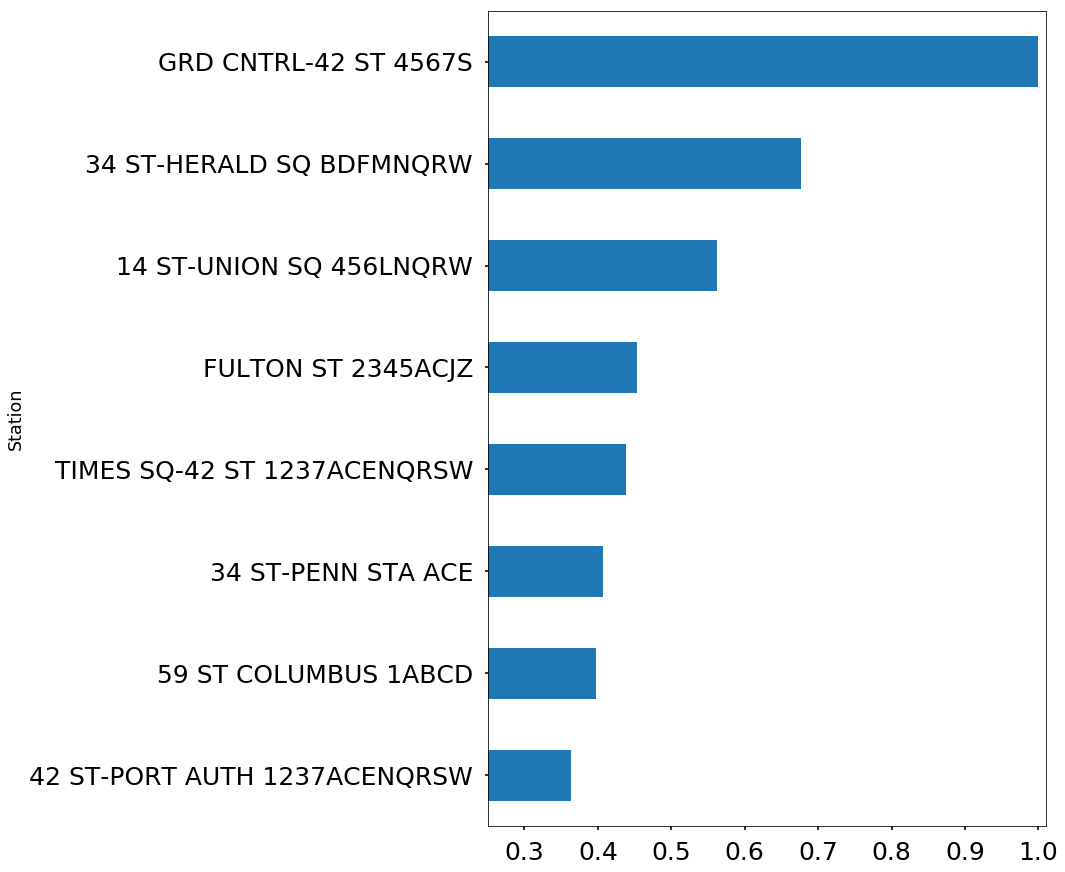

In [58]:
ax = a['wdEV'].sort_values().plot(kind='barh', figsize=(10, 15) ,legend=False, fontsize=25, xlim=[0.25,1.01])


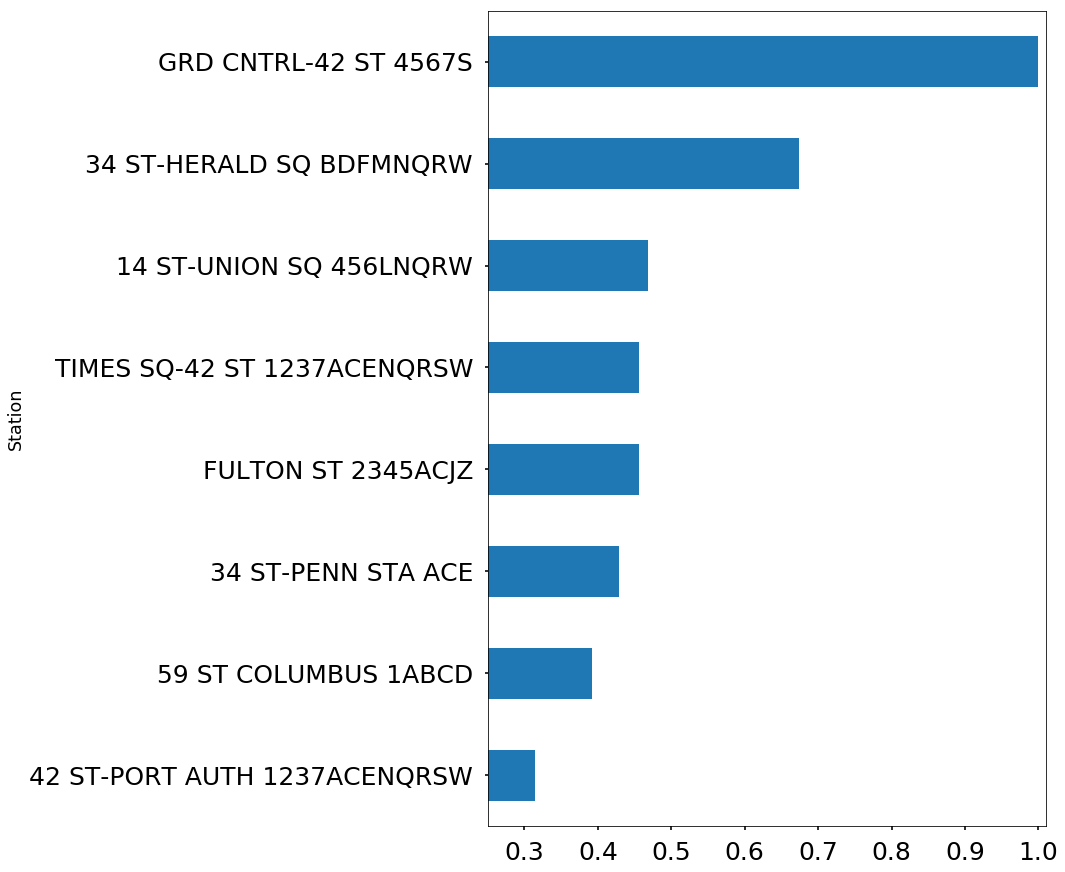

In [59]:
a['valfromc']=c['wdEV'].tolist()
ax = a['valfromc'].sort_values().plot(kind='barh', figsize=(10, 15),legend=False, fontsize=25, xlim=[0.25,1.01])
